In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import scripts.read_data_from_db as rd
import scripts.data_cleaning as dc
import scripts.write_to_db as wd
import scripts.utils as util

In [2]:
experience_df = rd.read_data(table_name='user_experience')
engagement_df = rd.read_data(table_name='user_engagement')

INFO:scripts.read_data_from_db:Data fetched succesfully
INFO:scripts.read_data_from_db:Data fetched succesfully


In [3]:
pysqldf = lambda q: sqldf(q, globals())

In [4]:
experience_df.head()

,CustomerID,AvgTCP,AvgRTT,AvgThroughput
0,3.360100e+10,1.000000,0.310549,0.000489
1,3.360100e+10,1.000000,0.009225,0.000864
2,3.360100e+10,1.000000,0.899082,0.000832
3,3.360101e+10,1.000000,0.498165,0.003294
4,3.360101e+10,0.713102,0.353618,0.462709


In [5]:
engagement_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
0,3.360100e+10,0.275973,0.0,0.508721
1,3.360100e+10,0.460555,0.0,0.017328
2,3.360100e+10,0.328189,0.0,0.316254
3,3.360101e+10,0.084717,0.0,0.198043
4,3.360101e+10,0.048167,0.5,0.902690


In [6]:
merged_df = engagement_df.merge(experience_df, left_on='MSISDN/Number', right_on="CustomerID", how='inner')
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput
0,3.360100e+10,0.275973,0.0,0.508721,3.360100e+10,1.000000,0.310549,0.000489
1,3.360100e+10,0.460555,0.0,0.017328,3.360100e+10,1.000000,0.009225,0.000864
2,3.360100e+10,0.328189,0.0,0.316254,3.360100e+10,1.000000,0.899082,0.000832
3,3.360101e+10,0.084717,0.0,0.198043,3.360101e+10,1.000000,0.498165,0.003294
4,3.360101e+10,0.048167,0.5,0.902690,3.360101e+10,0.713102,0.353618,0.462709


In [7]:
experience_columns = ["AvgTCP","AvgRTT","AvgThroughput"]
engagement_columns = ["SessionDuration","SessionFrequency","TotalTraffic"]

### Assigning scores

In [8]:
k = 3
X_eng = merged_df[engagement_columns]
X_exp = merged_df[experience_columns]

##### Assign engagement score

In [9]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_eng)
merged_df['cluster'] = cluster_labels

##### Get less engaged cluster

In [10]:
query = ''' 
    SELECT 
        cluster,
        AVG(("SessionDuration"+"SessionFrequency"+"TotalTraffic") / 3) AS AVG 
    FROM merged_df
    GROUP BY cluster;
'''

grouped = pysqldf(query)
less_engaged_cluster = grouped['AVG'].idxmin()
less_engaged_cluster

1

In [11]:
less_engaged_cluster_center = kmeans.cluster_centers_[less_engaged_cluster]

distances = euclidean_distances(X_eng, [less_engaged_cluster_center]).flatten()
merged_df['EngagementScore'] =  distances
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput,cluster,EngagementScore
0,3.360100e+10,0.275973,0.0,0.508721,3.360100e+10,1.000000,0.310549,0.000489,1,0.267089
1,3.360100e+10,0.460555,0.0,0.017328,3.360100e+10,1.000000,0.009225,0.000864,2,0.401371
2,3.360100e+10,0.328189,0.0,0.316254,3.360100e+10,1.000000,0.899082,0.000832,2,0.182542
3,3.360101e+10,0.084717,0.0,0.198043,3.360101e+10,1.000000,0.498165,0.003294,1,0.099873
4,3.360101e+10,0.048167,0.5,0.902690,3.360101e+10,0.713102,0.353618,0.462709,0,0.808767


##### Get worst experience cluster

In [12]:
query = ''' 
    SELECT 
        cluster,
        AVG(("AvgTCP" + "AvgRTT" + "AvgThroughput") / 3) AS AVG 
    FROM merged_df
    GROUP BY cluster;
'''

grouped = pysqldf(query)
worst_experience_cluster = grouped['AVG'].idxmin()
worst_experience_cluster

1

##### Assign Experience score

In [13]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_exp)

worst_experience_cluster_cluster_center = kmeans.cluster_centers_[worst_experience_cluster]

distances = euclidean_distances(X_eng, [worst_experience_cluster_cluster_center]).flatten()
merged_df['ExperienceScore'] =  distances
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput,cluster,EngagementScore,ExperienceScore
0,3.360100e+10,0.275973,0.0,0.508721,3.360100e+10,1.000000,0.310549,0.000489,1,0.267089,1.176596
1,3.360100e+10,0.460555,0.0,0.017328,3.360100e+10,1.000000,0.009225,0.000864,2,0.401371,0.989213
2,3.360100e+10,0.328189,0.0,0.316254,3.360100e+10,1.000000,0.899082,0.000832,2,0.182542,1.088511
3,3.360101e+10,0.084717,0.0,0.198043,3.360101e+10,1.000000,0.498165,0.003294,1,0.099873,1.228710
4,3.360101e+10,0.048167,0.5,0.902690,3.360101e+10,0.713102,0.353618,0.462709,0,0.808767,1.283376


#### Satisfaction Score

In [14]:
merged_df['SatisfactionScore'] = (merged_df['EngagementScore'] + merged_df['ExperienceScore']) / 2
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput,cluster,EngagementScore,ExperienceScore,SatisfactionScore
0,3.360100e+10,0.275973,0.0,0.508721,3.360100e+10,1.000000,0.310549,0.000489,1,0.267089,1.176596,0.721843
1,3.360100e+10,0.460555,0.0,0.017328,3.360100e+10,1.000000,0.009225,0.000864,2,0.401371,0.989213,0.695292
2,3.360100e+10,0.328189,0.0,0.316254,3.360100e+10,1.000000,0.899082,0.000832,2,0.182542,1.088511,0.635526
3,3.360101e+10,0.084717,0.0,0.198043,3.360101e+10,1.000000,0.498165,0.003294,1,0.099873,1.228710,0.664291
4,3.360101e+10,0.048167,0.5,0.902690,3.360101e+10,0.713102,0.353618,0.462709,0,0.808767,1.283376,1.046071


### Top satisfied users

In [15]:
query = ''' 
    SELECT 
        "MSISDN/Number",
        SatisfactionScore
    FROM merged_df
    ORDER BY SatisfactionScore DESC
    LIMIT 10
'''

pysqldf(query)

,MSISDN/Number,SatisfactionScore
0,3.360515e+10,1.224596
1,3.363873e+10,1.210582
2,3.368924e+10,1.209895
3,3.366811e+10,1.209179
4,3.366318e+10,1.208516
5,3.376164e+10,1.208094
6,3.365856e+10,1.207187
7,3.377035e+10,1.206766
8,3.365045e+10,1.205546
9,3.369970e+10,1.204865


In [16]:
merged_df['SatisfactionScore'].describe()

count    106856.000000
mean          0.710117
std           0.093412
min           0.595074
25%           0.649347
50%           0.685899
75%           0.737984
max           1.224596
Name: SatisfactionScore, dtype: float64

### Linear Regression

In [17]:
features = engagement_columns + experience_columns
X = merged_df[features]
y = merged_df.SatisfactionScore

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression() 
model.fit(X_train, y_train)

y_pred  = model.predict(X_test)


### KMeans clustering

In [18]:
selected_columns = ["EngagementScore", "SatisfactionScore"]
X = merged_df[selected_columns]
k = 2

kmeans = KMeans(n_clusters=k, random_state=0, n_init=15) 
kmeans.fit(X)

merged_df['cluster'] = kmeans.labels_

#### Clusters plot

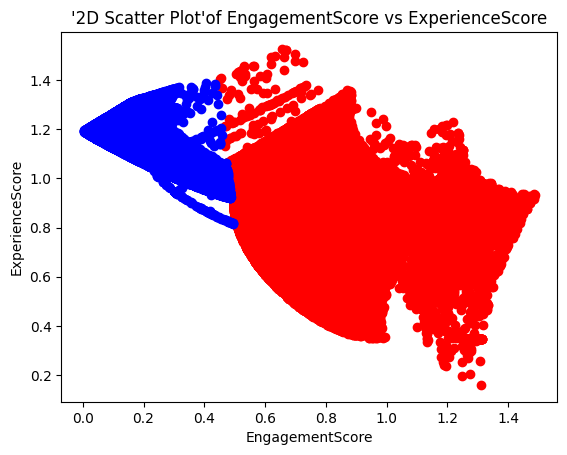

In [19]:
cluster_colors = {0: 'red', 1: 'blue'}
for cluster_label, color in cluster_colors.items():
    cluster_df = merged_df[merged_df["cluster"] == cluster_label]
    plt.scatter(cluster_df["EngagementScore"], cluster_df["ExperienceScore"], c=color)


plt.xlabel("EngagementScore")
plt.ylabel("ExperienceScore")
plt.title("'2D Scatter Plot'of EngagementScore vs ExperienceScore")

plt.show()

### Average Satisfaction per cluster


In [20]:
query = ''' 
    SELECT 
        cluster,
        AVG("SatisfactionScore") As "Average Satisfaction"
    FROM merged_df 
    GROUP BY cluster;
'''
avg_satsifaction = pysqldf(query)
avg_satsifaction

,cluster,Average Satisfaction
0,0,0.796233
1,1,0.676242


### Average experience Score per cluster

In [21]:
query = ''' 
    SELECT 
        cluster,
        AVG("ExperienceScore") AS "Average Experience" 
    FROM merged_df 
    GROUP BY cluster 
'''

avg_experience = pysqldf(query)
avg_experience

,cluster,Average Experience
0,0,0.837640
1,1,1.147008


In [22]:
df = pd.DataFrame({
    "UserID": merged_df["CustomerID"],
    "SatisfactionScore": merged_df["SatisfactionScore"],
    "ExperienceScore": merged_df["ExperienceScore"],
    "EngagementScore": merged_df["EngagementScore"]
})

wd.write_data(df, "satisfaction_score")

INFO:scripts.write_to_db:Data written successfully
